In [1]:
from astropy.io import fits
import numpy as np
import glob as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = '25'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [3]:
def raw_flux(data):
    correction_fac = data['AP_FACTOR'] / data['LSS_FACTOR'] * data['SSS_FACTOR'] * data['SENSCORR_FACTOR']
    count_to_flux = data['FLUX_HZ'] / data['SENSCORR_RATE']
    flux_tot = data['COI_TOT_RATE'] * correction_fac * count_to_flux
    flux_tot_err = data['COI_TOT_RATE_ERR'] * correction_fac * count_to_flux

    return (flux_tot, flux_tot_err)

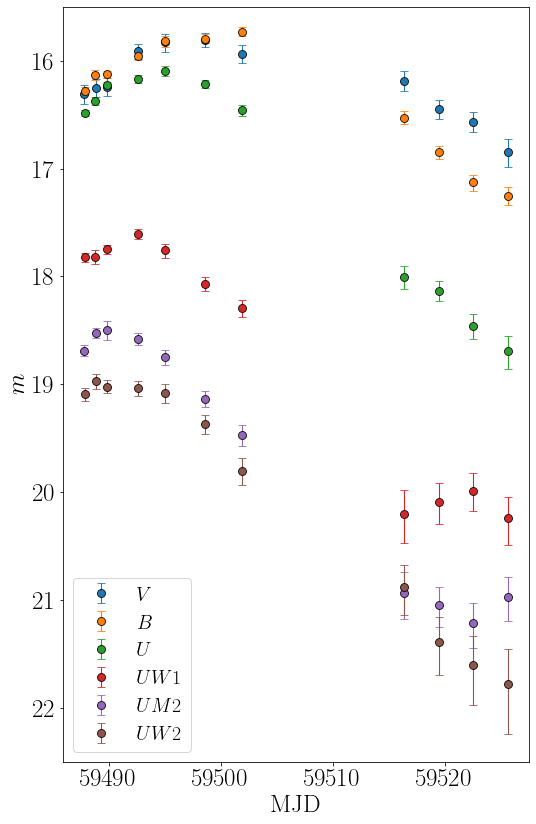

In [32]:
filt = ['V', 'B', 'U', 'UW1', 'UM2', 'UW2', 'W']
obsids = glob.glob(f'data/SN2021zny_5arcsec/*/')
obsids.sort()

#initialize a dictionary for photometric results
phot = {}

bkg = obsids[-1]
ims_bkg = glob.glob(bkg + 'uvot/image/*_stacked.out')

for k, obsid in enumerate(obsids[:-1]):
    # check if there is stacked file
    ims_stacked = glob.glob(obsid + 'uvot/image/*stacked.out')
    ims = glob.glob(obsid + 'uvot/image/*maghist.out')
    for flt in filt:
        stacked = False
        for im in ims_stacked:
            if im.split('/')[-1][:-12] == flt:
                stacked = True
                break
        hist = False
        if not stacked:
            for im in ims:
                if im.split('/')[-1][:-12] == flt:
                    hist = True
                    break
        if not (hist or stacked):
            #print(f'Cannot find {flt} band outputs.')
            continue
        for im_bkg in ims_bkg:
            if im_bkg.split('/')[-1][:-12] == flt:
                break
        data = fits.getdata(im)
        data_bkg = fits.getdata(im_bkg)
        flux_tot, flux_tot_err = raw_flux(data)  #total flux (including bkg)
        flux_bkg, flux_bkg_err = raw_flux(data_bkg)  #host galaxy flux (including bkg)
        snr = flux_tot / flux_tot_err
        mjd = np.array([])
        mag, mag_ulim, mag_llim = np.array([]), np.array([]), np.array([])
        lolim = np.array([])
        mjd = np.append(mjd, data['MET'] / 24 / 3600 +
                        51910)  # mission time + Jan 1.0, 2001
        for k in range(len(snr)):
            flux = flux_tot[k] - flux_bkg[0]
            flux_err = (flux_tot_err[k]**2 + flux_bkg_err[0]**2)**.5
            AB_mag = -2.5 * np.log10(flux / 3631e3)
            mag = np.append(mag, AB_mag)
            if ((snr[k] >= data['AB_MAG_LIM_SIG']).any()):
                AB_mag_up = -2.5 * np.log10((flux + flux_err) / 3631e3)
                AB_mag_lo = -2.5 * np.log10((flux - flux_err) / 3631e3)
                # pass the snr threshold
                mag_ulim = np.append(mag_ulim, AB_mag - AB_mag_up)
                mag_llim = np.append(mag_llim, AB_mag_lo - AB_mag)
                lolim = np.append(lolim, np.zeros_like(AB_mag))
            else:
                # low snr, provide lower limit
                AB_mag_lim = -2.5 * np.log10(
                    data['AB_FLUX_HZ_LIM'][k] / 3631e3)
                mag_ulim = np.append(mag_ulim, np.zeros_like(AB_mag))
                mag_llim = np.append(mag_llim, AB_mag_lim - AB_mag)
                lolim = np.append(lolim, np.ones_like(AB_mag))
        if not flt in phot.keys():
            phot[flt] = np.array([mjd, mag, mag_ulim, mag_llim, lolim])
        else:
            phot[flt] = np.append(phot[flt],
                                  np.array(
                                      [mjd, mag, mag_ulim, mag_llim, lolim]),
                                  axis=1)

f, ax = plt.subplots(figsize=(8, 12))
for flt in phot.keys():
    dat = phot[flt]
    if (~np.isnan(dat[0])).sum() == 0:
        continue
    # plot light curve
    ax.errorbar(dat[0],
                dat[1],
                yerr=(dat[2], dat[3]),
                lolims=dat[4],
                fmt='o',
                capsize=4,
                label=rf'${flt}$',
                markersize=8,
                markeredgecolor='k',
                markeredgewidth=.8,
                elinewidth=1.1)
ax.invert_yaxis()
ax.set_xlabel(r'$\mathrm{MJD}$')
ax.set_ylabel(r'$m$')
ax.legend(prop={'size':20})
f.tight_layout()
plt.ylim(22.5, 15.5)
plt.savefig('/Users/chang/Downloads/SN2021zny_5.pdf', bbox_inches='tight')
plt.show()

In [39]:
import pandas as pd
df = pd.DataFrame()
for flt in phot.keys():
    dat = phot[flt]
    dic = {'flt': [flt]*len(dat[0]), 'mjd':dat[0], 'mag':dat[1], 'mag_up_err':dat[2], 'mag_lo_err':dat[3], 'upper_lim':dat[4]==1}
    df = df.append(pd.DataFrame(dic))
df.to_csv('/Users/chang/Downloads/UVOT.csv', float_format="%.3f", index=False)

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/2084612310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/2084612310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/2084612310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/2084612310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(di

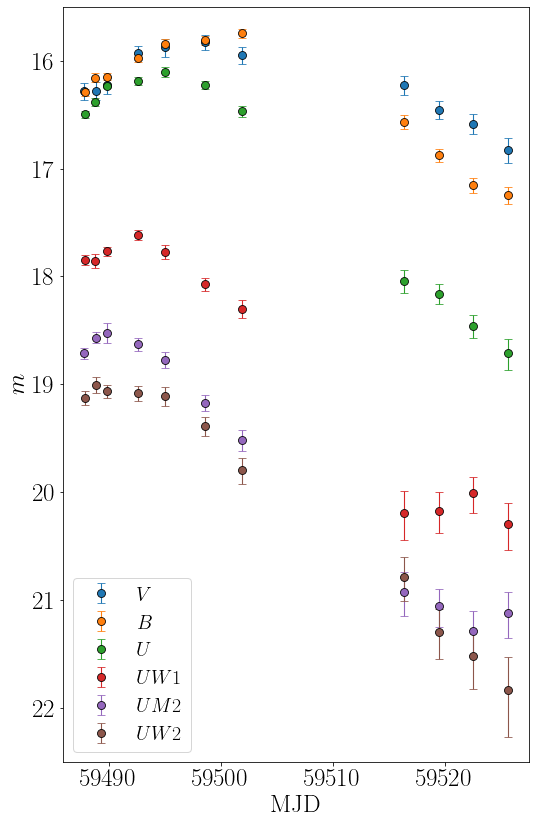

In [34]:
filt = ['V', 'B', 'U', 'UW1', 'UM2', 'UW2', 'W']
obsids = glob.glob(f'data/SN2021zny_4arcsec/*/')
obsids.sort()

#initialize a dictionary for photometric results
phot = {}

bkg = obsids[-1]
ims_bkg = glob.glob(bkg + 'uvot/image/*_stacked.out')

for k, obsid in enumerate(obsids[:-1]):
    # check if there is stacked file
    ims_stacked = glob.glob(obsid + 'uvot/image/*stacked.out')
    ims = glob.glob(obsid + 'uvot/image/*maghist.out')
    for flt in filt:
        stacked = False
        for im in ims_stacked:
            if im.split('/')[-1][:-12] == flt:
                stacked = True
                break
        hist = False
        if not stacked:
            for im in ims:
                if im.split('/')[-1][:-12] == flt:
                    hist = True
                    break
        if not (hist or stacked):
            #print(f'Cannot find {flt} band outputs.')
            continue
        for im_bkg in ims_bkg:
            if im_bkg.split('/')[-1][:-12] == flt:
                break
        data = fits.getdata(im)
        data_bkg = fits.getdata(im_bkg)
        flux_tot, flux_tot_err = raw_flux(data)  #total flux (including bkg)
        flux_bkg, flux_bkg_err = raw_flux(data_bkg)  #host galaxy flux (including bkg)
        snr = flux_tot / flux_tot_err
        mjd = np.array([])
        mag, mag_ulim, mag_llim = np.array([]), np.array([]), np.array([])
        lolim = np.array([])
        mjd = np.append(mjd, data['MET'] / 24 / 3600 +
                        51910)  # mission time + Jan 1.0, 2001
        for k in range(len(snr)):
            flux = flux_tot[k] - flux_bkg[0]
            flux_err = (flux_tot_err[k]**2 + flux_bkg_err[0]**2)**.5
            AB_mag = -2.5 * np.log10(flux / 3631e3)
            mag = np.append(mag, AB_mag)
            if ((snr[k] >= data['AB_MAG_LIM_SIG']).any()):
                AB_mag_up = -2.5 * np.log10((flux + flux_err) / 3631e3)
                AB_mag_lo = -2.5 * np.log10((flux - flux_err) / 3631e3)
                # pass the snr threshold
                mag_ulim = np.append(mag_ulim, AB_mag - AB_mag_up)
                mag_llim = np.append(mag_llim, AB_mag_lo - AB_mag)
                lolim = np.append(lolim, np.zeros_like(AB_mag))
            else:
                # low snr, provide lower limit
                AB_mag_lim = -2.5 * np.log10(
                    data['AB_FLUX_HZ_LIM'][k] / 3631e3)
                mag_ulim = np.append(mag_ulim, np.zeros_like(AB_mag))
                mag_llim = np.append(mag_llim, AB_mag_lim - AB_mag)
                lolim = np.append(lolim, np.ones_like(AB_mag))
        if not flt in phot.keys():
            phot[flt] = np.array([mjd, mag, mag_ulim, mag_llim, lolim])
        else:
            phot[flt] = np.append(phot[flt],
                                  np.array(
                                      [mjd, mag, mag_ulim, mag_llim, lolim]),
                                  axis=1)

f, ax = plt.subplots(figsize=(8, 12))
for flt in phot.keys():
    dat = phot[flt]
    if (~np.isnan(dat[0])).sum() == 0:
        continue
    # plot light curve
    ax.errorbar(dat[0],
                dat[1],
                yerr=(dat[2], dat[3]),
                lolims=dat[4],
                fmt='o',
                capsize=4,
                label=rf'${flt}$',
                markersize=8,
                markeredgecolor='k',
                markeredgewidth=.8,
                elinewidth=1.1)
ax.invert_yaxis()
ax.set_xlabel(r'$\mathrm{MJD}$')
ax.set_ylabel(r'$m$')
ax.legend(prop={'size':20})
f.tight_layout()
plt.ylim(22.5, 15.5)
plt.savefig('/Users/chang/Downloads/SN2021zny_4.pdf', bbox_inches='tight')
plt.show()

In [35]:
import pandas as pd
df = pd.DataFrame()
for flt in phot.keys():
    dat = phot[flt]
    dic = {'flt': [flt]*len(dat[0]), 'mjd':dat[0], 'mag':dat[1], 'mag_up_err':dat[2], 'mag_lo_err':dat[3], 'upper_lim':dat[4]}
    df = df.append(pd.DataFrame(dic))
df

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/3963613399.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/3963613399.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/3963613399.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(dic))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_52880/3963613399.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(di

,flt,mjd,mag,mag_up_err,mag_lo_err,upper_lim
0,V,59487.834535,16.285027,0.077045,0.082933,0.0
1,V,59488.830862,16.278678,0.076867,0.082726,0.0
2,V,59489.831295,16.229052,0.074677,0.080195,0.0
3,V,59492.645872,15.930256,0.063091,0.066985,0.0
4,V,59495.056108,15.874470,0.080366,0.086794,0.0
...,...,...,...,...,...,...
6,UW2,59501.891929,19.797802,0.115297,0.129011,0.0
7,UW2,59516.363921,20.789649,0.185338,0.223623,0.0
8,UW2,59519.460158,21.296300,0.206990,0.255973,0.0
9,UW2,59522.540738,21.522559,0.239053,0.306999,0.0
